In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from xgboost import plot_importance


# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO1_preprocessed.csv', parse_dates=['datetime'])

data=data.set_index('datetime')
data.drop('reservoir_capacity', 1, inplace=True)




/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/67418350.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('reservoir_capacity', 1, inplace=True)


In [2]:
def prepare_data(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [3]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data(data)

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

In [5]:
tscv = TimeSeriesSplit(n_splits=365, test_size=24)

In [6]:

val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_val, label=y_val)
    
        # set hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda':0.2
    }

    # train model
    num_rounds = 100
    model = xgb.train(params, train_dmatrix, num_rounds)

    # predict on test set
    preds = model.predict(test_dmatrix)

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))
    

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast=pd.Series()
365it [04:20,  1.40it/s]


In [7]:
# compute the residuals
residuals = train_set['target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  1.618243676620295e+18
Mean RMSE: 39476.522048830404
Mean MAPE: 135.40456466818904
Mean MAE: 33473.27609361622


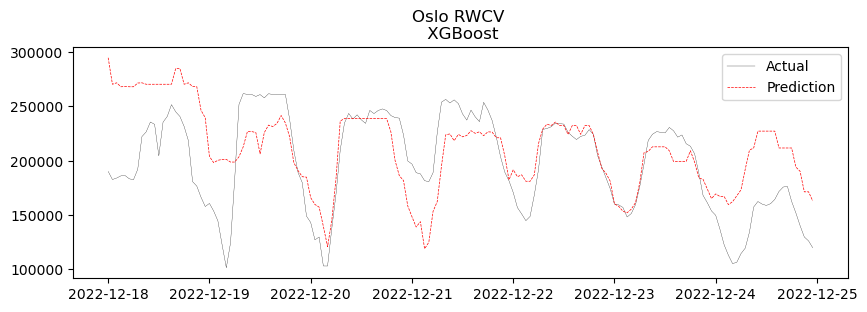

In [8]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)

train_set.index.freq = 'H'

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*13:-24*6], train_set['target'][-24*14:-24*7].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*13:-24*6], forecast[-24*14:-24*7], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Oslo RWCV \n XGBoost')
plt.legend()
plt.show()



In [9]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


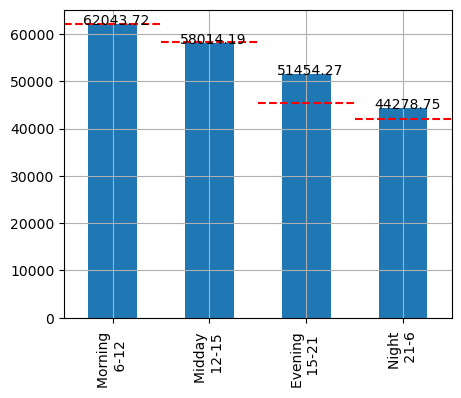

In [10]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=62023, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=58327, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=45331, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=41924, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    

plt.show()

In [11]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


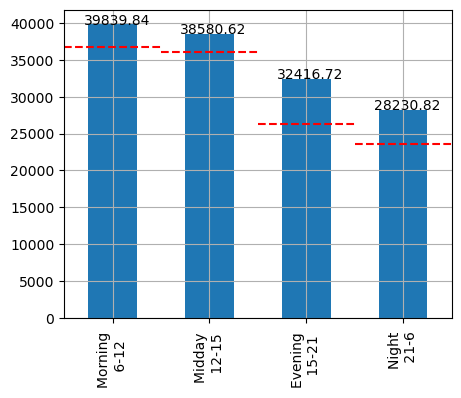

In [12]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=36809, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=36069, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=26361, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=23577, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

Residual Sum of Squares (RSS):  1546385846933.0098
RMSE: 27052.6108, MAPE: 26.9288% , MAE:  18838.7446, RSS:  1546385846933.0098


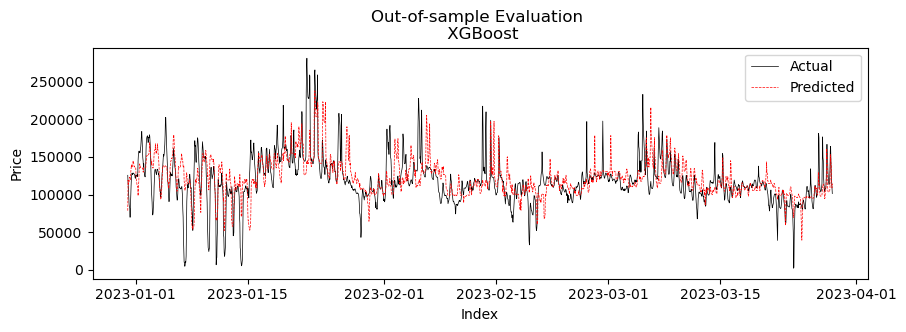

In [13]:

# prepare data
train_dmatrix = xgb.DMatrix(train_X, label=train_y)
test_dmatrix = xgb.DMatrix(test_X, label=test_y)

# set hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda':0.2
}

# train model
num_rounds = 100
model = xgb.train(params, train_dmatrix, num_rounds)

# predict on test set
preds = model.predict(test_dmatrix)

# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Out-of-sample Evaluation \n XGBoost')
plt.legend()
plt.show()


In [14]:
orig_feature_names = train_set.drop('target', 1).columns
orig_feature_names

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/2618380972.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  orig_feature_names = train_set.drop('target', 1).columns


Index(['price', 'consumption', 'production', 'da_production',
       'exchange_NO1_NO2', 'exchange_NO1_NO3', 'exchange_NO1_NO5',
       'exchange_NO1_SE3', 'air_temperature', 'wind_speed',
       'precipitation_amount', 'reservoir_levels', 'oil_price', 'gas_price',
       'osebx_price'],
      dtype='object')

In [15]:
importance = model.get_score(importance_type='gain')
importance

{'f0': 33.045555114746094,
 'f1': 0.36057615280151367,
 'f2': 0.3297620415687561,
 'f3': 0.5138480067253113,
 'f4': 0.23656071722507477,
 'f5': 0.11242999881505966,
 'f6': 0.28946349024772644,
 'f7': 0.23358096182346344,
 'f8': 0.45304885506629944,
 'f9': 0.8313062191009521,
 'f10': 0.7816285490989685,
 'f11': 1.9448802471160889,
 'f12': 12.202659606933594,
 'f13': 2.608978033065796,
 'f14': 3.710547685623169}

In [16]:
feature_importance = {orig_feature_names[int(key[1:])]: value for key, value in importance.items()}
feature_importance

{'price': 33.045555114746094,
 'consumption': 0.36057615280151367,
 'production': 0.3297620415687561,
 'da_production': 0.5138480067253113,
 'exchange_NO1_NO2': 0.23656071722507477,
 'exchange_NO1_NO3': 0.11242999881505966,
 'exchange_NO1_NO5': 0.28946349024772644,
 'exchange_NO1_SE3': 0.23358096182346344,
 'air_temperature': 0.45304885506629944,
 'wind_speed': 0.8313062191009521,
 'precipitation_amount': 0.7816285490989685,
 'reservoir_levels': 1.9448802471160889,
 'oil_price': 12.202659606933594,
 'gas_price': 2.608978033065796,
 'osebx_price': 3.710547685623169}

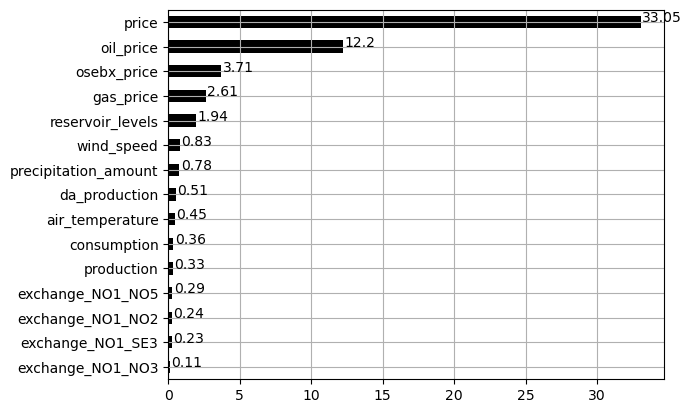

In [17]:
# create a pandas series and sort by values
feature_importance = pd.Series(feature_importance).sort_values()

# create horizontal bar chart
ax = feature_importance.plot(kind='barh', color='black', grid=True)

# loop over series and annotate bars
for i, v in enumerate(feature_importance):
    ax.text(v + 0.1, i, str(round(v, 2)), color='black')
    
# show plot
plt.show()

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from xgboost import plot_importance


# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO2_preprocessed.csv', parse_dates=['datetime'])

data=data.set_index('datetime')
data.drop('reservoir_capacity', 1, inplace=True)




/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/4159970076.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('reservoir_capacity', 1, inplace=True)


In [19]:
def prepare_data(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [20]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data(data)

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm

In [22]:
tscv = TimeSeriesSplit(n_splits=365, test_size=24)

In [23]:

val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_val, label=y_val)
    
        # set hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda':0.2
    }

    # train model
    num_rounds = 100
    model = xgb.train(params, train_dmatrix, num_rounds)

    # predict on test set
    preds = model.predict(test_dmatrix)

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))
    

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast=pd.Series()
365it [06:59,  1.15s/it]


In [24]:
# compute the residuals
residuals = train_set['target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)
print("Residual Sum of Squares (RSS): ", rss)
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))
print("Mean MAE:", np.mean(mae))

Residual Sum of Squares (RSS):  2.152631265817642e+18
Mean RMSE: 45920.17954784829
Mean MAPE: 153.3517108408262
Mean MAE: 39101.77990941262


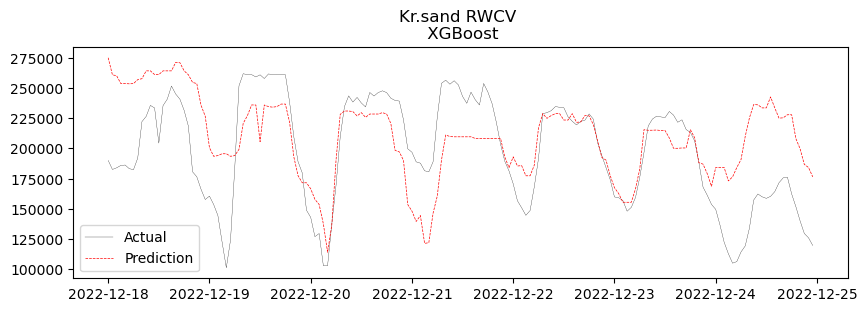

In [25]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)

train_set.index.freq = 'H'

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*13:-24*6], train_set['target'][-24*14:-24*7].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*13:-24*6], forecast[-24*14:-24*7], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Kr.sand RWCV \n XGBoost')
plt.legend()
plt.show()



In [26]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


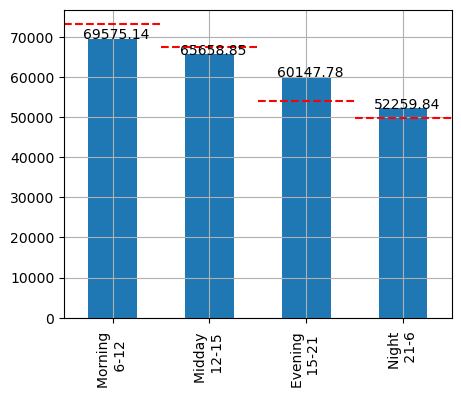

In [27]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=73173, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=67576, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=53986, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=49911, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    
plt.show()

In [28]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


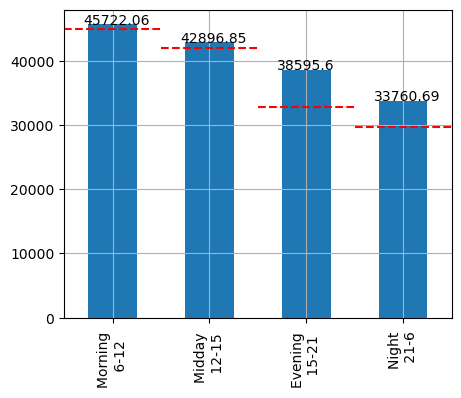

In [29]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=44972, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=42098, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=32833, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=29745, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

Residual Sum of Squares (RSS):  1570183715842.851
RMSE: 27259.9771, MAPE: 26.1955% , MAE:  19266.8822, RSS:  1570183715842.8511


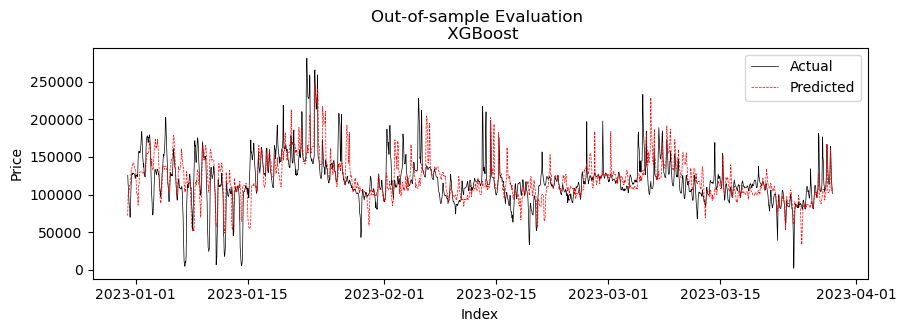

In [30]:

# prepare data
train_dmatrix = xgb.DMatrix(train_X, label=train_y)
test_dmatrix = xgb.DMatrix(test_X, label=test_y)

# set hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda':0.2
}

# train model
num_rounds = 100
model = xgb.train(params, train_dmatrix, num_rounds)

# predict on test set
preds = model.predict(test_dmatrix)

# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Out-of-sample Evaluation \n XGBoost')
plt.legend()
plt.show()


In [31]:
orig_feature_names = train_set.drop('target', 1).columns
orig_feature_names

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/2618380972.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  orig_feature_names = train_set.drop('target', 1).columns


Index(['price', 'consumption', 'production', 'da_production',
       'exchange_NO1_NO2', 'exchange_NO2_NL', 'exchange_NO2_NO5',
       'air_temperature', 'wind_speed', 'precipitation_amount',
       'reservoir_levels', 'oil_price', 'gas_price', 'osebx_price'],
      dtype='object')

In [32]:
importance = model.get_score(importance_type='gain')
importance

{'f0': 41.009918212890625,
 'f1': 0.2280968576669693,
 'f2': 0.8507272601127625,
 'f3': 1.2404001951217651,
 'f4': 0.2552470564842224,
 'f5': 0.609868049621582,
 'f6': 0.3631324768066406,
 'f7': 1.2386411428451538,
 'f8': 0.6946592926979065,
 'f9': 0.6133076548576355,
 'f10': 2.766659736633301,
 'f11': 4.610176086425781,
 'f12': 2.3979885578155518,
 'f13': 3.522479772567749}

In [33]:
feature_importance = {orig_feature_names[int(key[1:])]: value for key, value in importance.items()}
feature_importance

{'price': 41.009918212890625,
 'consumption': 0.2280968576669693,
 'production': 0.8507272601127625,
 'da_production': 1.2404001951217651,
 'exchange_NO1_NO2': 0.2552470564842224,
 'exchange_NO2_NL': 0.609868049621582,
 'exchange_NO2_NO5': 0.3631324768066406,
 'air_temperature': 1.2386411428451538,
 'wind_speed': 0.6946592926979065,
 'precipitation_amount': 0.6133076548576355,
 'reservoir_levels': 2.766659736633301,
 'oil_price': 4.610176086425781,
 'gas_price': 2.3979885578155518,
 'osebx_price': 3.522479772567749}

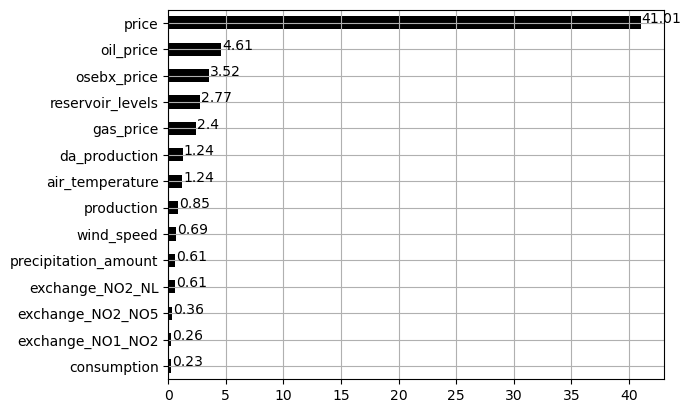

In [34]:
# create a pandas series and sort by values
feature_importance = pd.Series(feature_importance).sort_values()

# create horizontal bar chart
ax = feature_importance.plot(kind='barh', color='black', grid=True)

# loop over series and annotate bars
for i, v in enumerate(feature_importance):
    ax.text(v + 0.1, i, str(round(v, 2)), color='black')
    
# show plot
plt.show()

In [35]:

# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO3_preprocessed.csv', parse_dates=['datetime'])

data=data.set_index('datetime')
data.drop('reservoir_capacity', 1, inplace=True)




/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/3688569846.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('reservoir_capacity', 1, inplace=True)


In [36]:
def prepare_data(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [37]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data(data)

In [38]:
tscv = TimeSeriesSplit(n_splits=365, test_size=24)

In [39]:

val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_val, label=y_val)
    
        # set hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda':0.2
    }

    # train model
    num_rounds = 100
    model = xgb.train(params, train_dmatrix, num_rounds)

    # predict on test set
    preds = model.predict(test_dmatrix)

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))
    

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast=pd.Series()
280it [05:39,  1.20s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:40: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
314it [06:25,  1.38s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:40: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
315it [06:26,  1.33s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:40: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
365it [07:34,  1.24s/it]


In [40]:
# compute the residuals
residuals = train_set['target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)
print("Residual Sum of Squares (RSS): ", rss)
print("Mean MAE:", np.mean(mae))
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))

Residual Sum of Squares (RSS):  6.282206985805347e+17
Mean MAE: 19455.728074497936
Mean RMSE: 23339.97780955492
Mean MAPE: inf


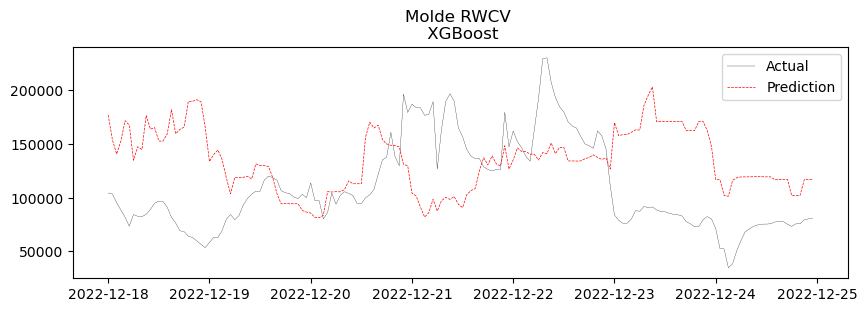

In [41]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)


train_set.index.freq = 'H'

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*13:-24*6], train_set['target'][-24*14:-24*7].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*13:-24*6], forecast[-24*14:-24*7], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Molde RWCV \n XGBoost')
plt.legend()
plt.show()



In [42]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


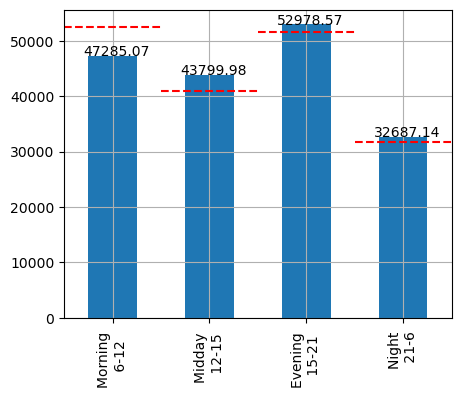

In [43]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=52421, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=40960, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=51591, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=31776, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    

plt.show()

In [44]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


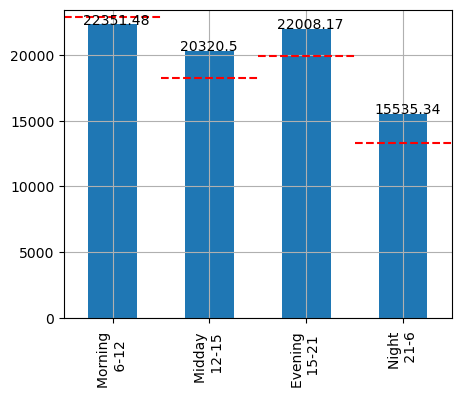

In [45]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=22891, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=18225, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=19937, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=13290, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))



plt.show()

Residual Sum of Squares (RSS):  1785539730477.586
RMSE: 29069.3292, MAPE: 31.7915% , MAE:  19666.5445, RSS:  1785539730477.5859


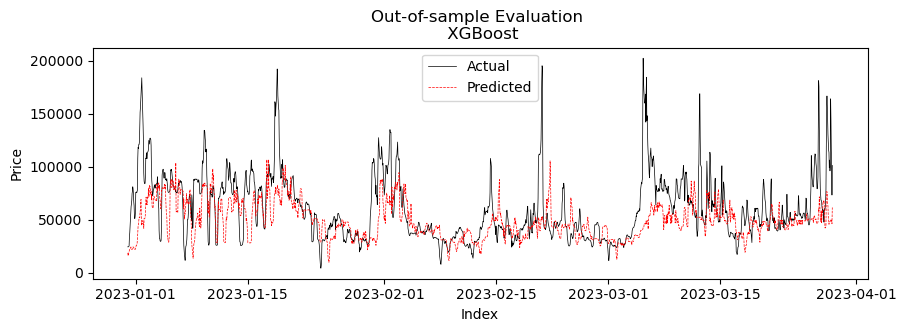

In [46]:

# prepare data
train_dmatrix = xgb.DMatrix(train_X, label=train_y)
test_dmatrix = xgb.DMatrix(test_X, label=test_y)

# set hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda':0.2
}

# train model
num_rounds = 100
model = xgb.train(params, train_dmatrix, num_rounds)

# predict on test set
preds = model.predict(test_dmatrix)

# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Out-of-sample Evaluation \n XGBoost')
plt.legend()
plt.show()


In [47]:
orig_feature_names = train_set.drop('target', 1).columns
orig_feature_names

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/2618380972.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  orig_feature_names = train_set.drop('target', 1).columns


Index(['price', 'consumption', 'production', 'da_production',
       'exchange_NO1_NO3', 'exchange_NO3_NO4', 'exchange_NO3_NO5',
       'exchange_NO3_SE2', 'air_temperature', 'wind_speed',
       'precipitation_amount', 'reservoir_levels', 'oil_price', 'gas_price',
       'osebx_price'],
      dtype='object')

In [48]:
importance = model.get_score(importance_type='gain')
importance

{'f0': 8.036014556884766,
 'f1': 0.9173227548599243,
 'f2': 0.4309720993041992,
 'f3': 0.911013662815094,
 'f4': 0.27963048219680786,
 'f5': 0.6324636936187744,
 'f6': 0.13089169561862946,
 'f7': 0.5937560796737671,
 'f8': 0.7688448429107666,
 'f9': 0.8345442414283752,
 'f10': 0.7660706639289856,
 'f11': 1.3487640619277954,
 'f12': 3.7284786701202393,
 'f13': 1.5128891468048096,
 'f14': 1.2766151428222656}

In [49]:
feature_importance = {orig_feature_names[int(key[1:])]: value for key, value in importance.items()}
feature_importance

{'price': 8.036014556884766,
 'consumption': 0.9173227548599243,
 'production': 0.4309720993041992,
 'da_production': 0.911013662815094,
 'exchange_NO1_NO3': 0.27963048219680786,
 'exchange_NO3_NO4': 0.6324636936187744,
 'exchange_NO3_NO5': 0.13089169561862946,
 'exchange_NO3_SE2': 0.5937560796737671,
 'air_temperature': 0.7688448429107666,
 'wind_speed': 0.8345442414283752,
 'precipitation_amount': 0.7660706639289856,
 'reservoir_levels': 1.3487640619277954,
 'oil_price': 3.7284786701202393,
 'gas_price': 1.5128891468048096,
 'osebx_price': 1.2766151428222656}

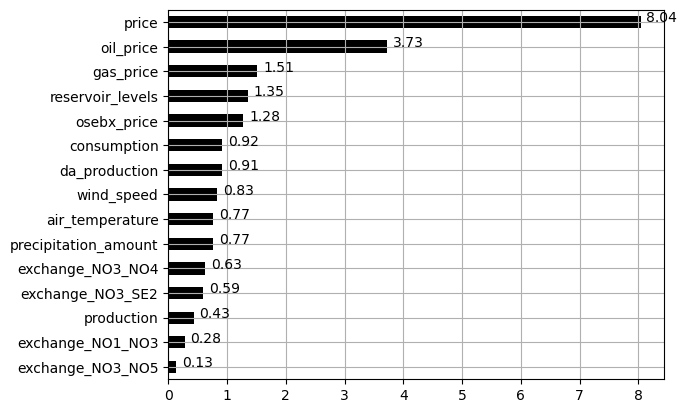

In [50]:
# create a pandas series and sort by values
feature_importance = pd.Series(feature_importance).sort_values()

# create horizontal bar chart
ax = feature_importance.plot(kind='barh', color='black', grid=True)

# loop over series and annotate bars
for i, v in enumerate(feature_importance):
    ax.text(v + 0.1, i, str(round(v, 2)), color='black')
    
# show plot
plt.show()

In [51]:

# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO4_preprocessed.csv', parse_dates=['datetime'])

data=data.set_index('datetime')
data.drop('reservoir_capacity', 1, inplace=True)




/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/121917515.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('reservoir_capacity', 1, inplace=True)


In [52]:
def prepare_data(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [53]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data(data)

In [54]:
tscv = TimeSeriesSplit(n_splits=365, test_size=24)

In [55]:

val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_val, label=y_val)
    
        # set hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda':0.2
    }

    # train model
    num_rounds = 100
    model = xgb.train(params, train_dmatrix, num_rounds)

    # predict on test set
    preds = model.predict(test_dmatrix)

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))
    

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast=pd.Series()
280it [05:26,  1.46s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:40: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
314it [06:14,  1.42s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:40: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
315it [06:16,  1.44s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:40: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
365it [07:18,  1.20s/it]


In [56]:
# compute the residuals
residuals = train_set['target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)
print("Residual Sum of Squares (RSS): ", rss)
print("Mean MAE:", np.mean(mae))
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))

Residual Sum of Squares (RSS):  2.3933416361812067e+17
Mean MAE: 10946.096555095612
Mean RMSE: 13179.716813970643
Mean MAPE: inf


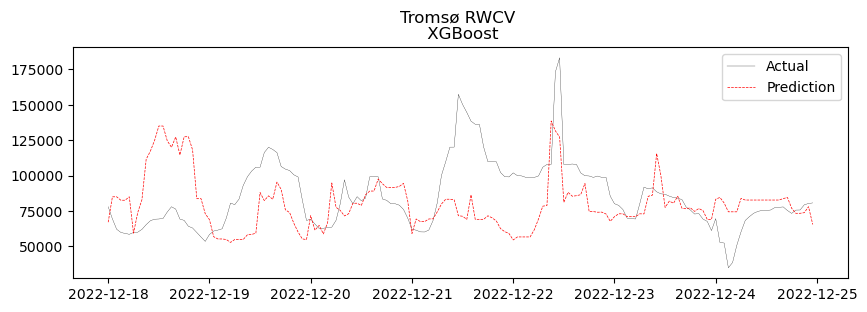

In [57]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)


train_set.index.freq = 'H'

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*13:-24*6], train_set['target'][-24*14:-24*7].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*13:-24*6], forecast[-24*14:-24*7], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Tromsø RWCV \n XGBoost')
plt.legend()
plt.show()



In [58]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


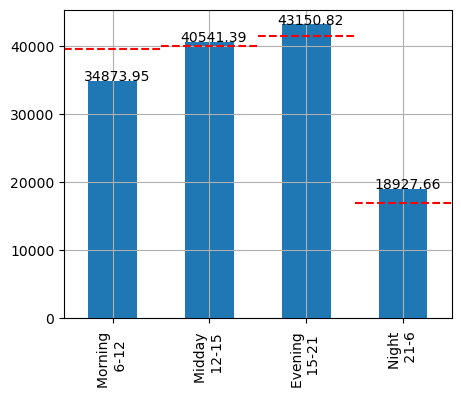

In [59]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=39456, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=40010, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=41405, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=16851, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    

plt.show()

In [60]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


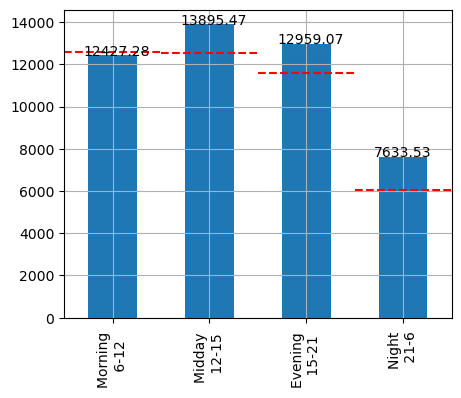

In [61]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))

for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=12597, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=12547, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=11571, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=6047, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

Residual Sum of Squares (RSS):  1132373880624.7397
RMSE: 23149.6897, MAPE: 29.3554% , MAE:  12507.3118, RSS:  1132373880624.7397


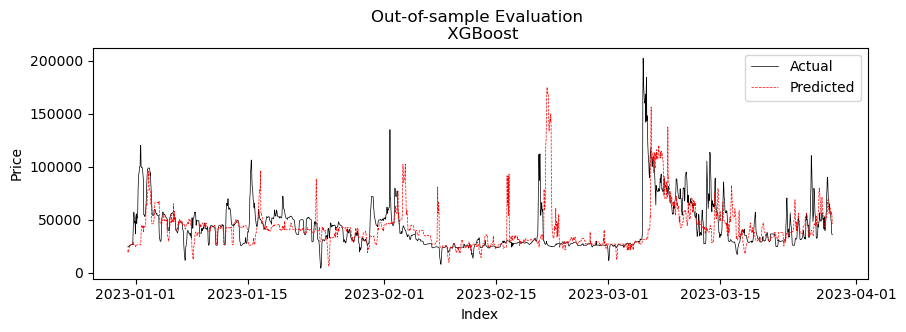

In [62]:

# prepare data
train_dmatrix = xgb.DMatrix(train_X, label=train_y)
test_dmatrix = xgb.DMatrix(test_X, label=test_y)

# set hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda':0.2
}

# train model
num_rounds = 100
model = xgb.train(params, train_dmatrix, num_rounds)

# predict on test set
preds = model.predict(test_dmatrix)

# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Out-of-sample Evaluation \n XGBoost')
plt.legend()
plt.show()


In [63]:
orig_feature_names = train_set.drop('target', 1).columns
orig_feature_names

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/2618380972.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  orig_feature_names = train_set.drop('target', 1).columns


Index(['price', 'consumption', 'production', 'da_production',
       'exchange_NO3_NO4', 'exchange_NO4_SE1', 'exchange_NO4_SE2',
       'air_temperature', 'wind_speed', 'precipitation_amount',
       'reservoir_levels', 'oil_price', 'gas_price', 'osebx_price'],
      dtype='object')

In [64]:
importance = model.get_score(importance_type='gain')
importance

{'f0': 4.639822006225586,
 'f1': 0.45902425050735474,
 'f2': 0.34690943360328674,
 'f3': 1.029557466506958,
 'f4': 0.8574213981628418,
 'f5': 0.42191314697265625,
 'f6': 0.751288115978241,
 'f7': 1.2323875427246094,
 'f8': 1.695469856262207,
 'f9': 0.6207798719406128,
 'f10': 0.6838834285736084,
 'f11': 0.5134257674217224,
 'f12': 0.6467745900154114,
 'f13': 0.4744625389575958}

In [65]:
feature_importance = {orig_feature_names[int(key[1:])]: value for key, value in importance.items()}
feature_importance

{'price': 4.639822006225586,
 'consumption': 0.45902425050735474,
 'production': 0.34690943360328674,
 'da_production': 1.029557466506958,
 'exchange_NO3_NO4': 0.8574213981628418,
 'exchange_NO4_SE1': 0.42191314697265625,
 'exchange_NO4_SE2': 0.751288115978241,
 'air_temperature': 1.2323875427246094,
 'wind_speed': 1.695469856262207,
 'precipitation_amount': 0.6207798719406128,
 'reservoir_levels': 0.6838834285736084,
 'oil_price': 0.5134257674217224,
 'gas_price': 0.6467745900154114,
 'osebx_price': 0.4744625389575958}

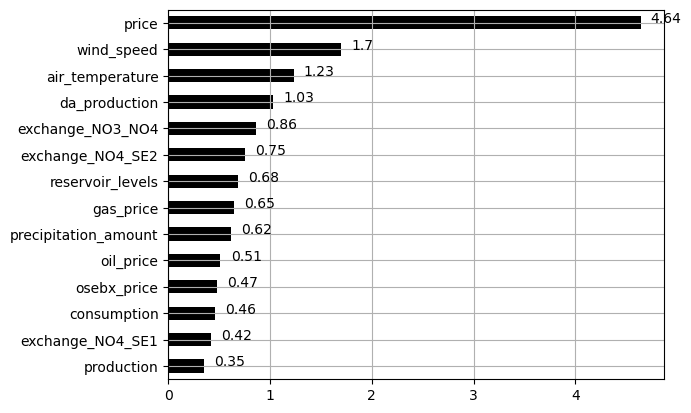

In [66]:
# create a pandas series and sort by values
feature_importance = pd.Series(feature_importance).sort_values()

# create horizontal bar chart
ax = feature_importance.plot(kind='barh', color='black', grid=True)

# loop over series and annotate bars
for i, v in enumerate(feature_importance):
    ax.text(v + 0.1, i, str(round(v, 2)), color='black')
    
# show plot
plt.show()

In [67]:

# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO5_preprocessed.csv', parse_dates=['datetime'])

data=data.set_index('datetime')
data.drop('reservoir_capacity', 1, inplace=True)




/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/4132540769.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('reservoir_capacity', 1, inplace=True)


In [68]:
def prepare_data(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [69]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data(data)

In [70]:
tscv = TimeSeriesSplit(n_splits=365, test_size=24)

In [71]:

val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_val, label=y_val)
    
        # set hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda':0.2
    }

    # train model
    num_rounds = 100
    model = xgb.train(params, train_dmatrix, num_rounds)

    # predict on test set
    preds = model.predict(test_dmatrix)

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))
    

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast=pd.Series()
365it [07:30,  1.23s/it]


In [72]:
# compute the residuals
residuals = train_set['target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)
print("Residual Sum of Squares (RSS): ", rss)
print("Mean MAE:", np.mean(mae))
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))

Residual Sum of Squares (RSS):  1.6350521341375168e+18
Mean MAE: 33479.723063485486
Mean RMSE: 39165.13826950844
Mean MAPE: 154.40250927284083


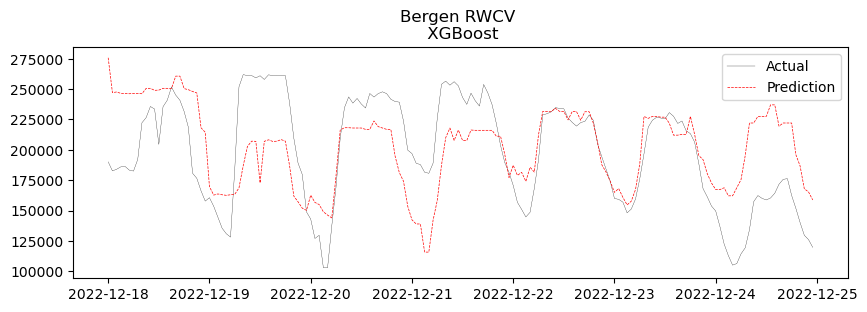

In [73]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)

train_set.index.freq = 'H'

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*13:-24*6], train_set['target'][-24*14:-24*7].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*13:-24*6], forecast[-24*14:-24*7], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Bergen RWCV \n XGBoost')
plt.legend()
plt.show()



In [74]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


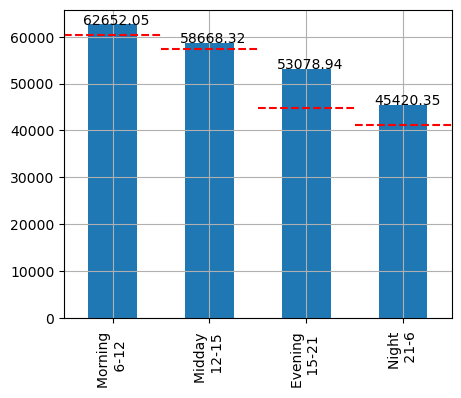

In [75]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=60297, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=57312, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=44719, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=41079, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    

plt.show()

In [76]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


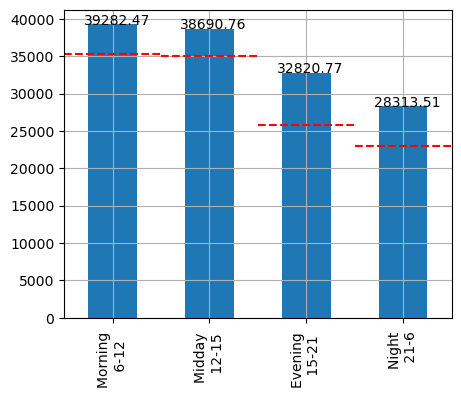

In [77]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=35282, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=35024, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=25820, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=23032, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

Residual Sum of Squares (RSS):  1232980915913.6602
RMSE: 24156.1895, MAPE: 15.9431% , MAE:  17018.1906, RSS:  1232980915913.6602


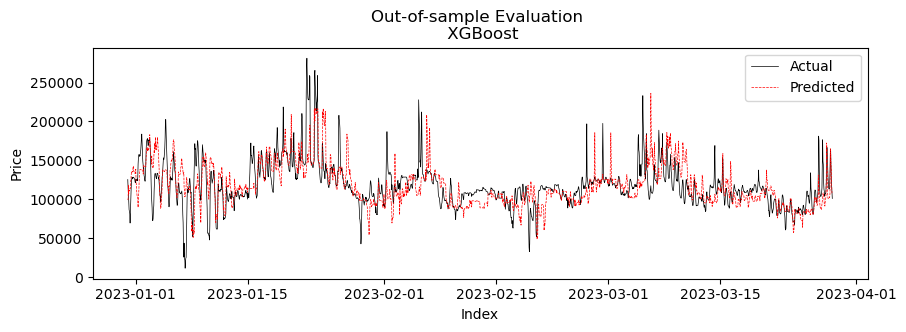

In [78]:

# prepare data
train_dmatrix = xgb.DMatrix(train_X, label=train_y)
test_dmatrix = xgb.DMatrix(test_X, label=test_y)

# set hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda':0.2
}

# train model
num_rounds = 100
model = xgb.train(params, train_dmatrix, num_rounds)

# predict on test set
preds = model.predict(test_dmatrix)

# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Out-of-sample Evaluation \n XGBoost')
plt.legend()
plt.show()


In [79]:
orig_feature_names = train_set.drop('target', 1).columns
orig_feature_names

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/2618380972.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  orig_feature_names = train_set.drop('target', 1).columns


Index(['price', 'consumption', 'production', 'da_production',
       'exchange_NO1_NO5', 'exchange_NO2_NO5', 'exchange_NO3_NO5',
       'air_temperature', 'wind_speed', 'precipitation_amount',
       'reservoir_levels', 'oil_price', 'gas_price', 'osebx_price'],
      dtype='object')

In [80]:
importance = model.get_score(importance_type='gain')
importance

{'f0': 33.96931076049805,
 'f1': 0.3161512315273285,
 'f2': 0.6956523656845093,
 'f3': 0.6602230668067932,
 'f4': 0.24333590269088745,
 'f5': 0.288614422082901,
 'f6': 0.45021048188209534,
 'f7': 0.5883514285087585,
 'f8': 1.0882445573806763,
 'f9': 0.5215522050857544,
 'f10': 1.214734673500061,
 'f11': 3.7619524002075195,
 'f12': 2.0126028060913086,
 'f13': 2.907210350036621}

In [81]:
feature_importance = {orig_feature_names[int(key[1:])]: value for key, value in importance.items()}
feature_importance

{'price': 33.96931076049805,
 'consumption': 0.3161512315273285,
 'production': 0.6956523656845093,
 'da_production': 0.6602230668067932,
 'exchange_NO1_NO5': 0.24333590269088745,
 'exchange_NO2_NO5': 0.288614422082901,
 'exchange_NO3_NO5': 0.45021048188209534,
 'air_temperature': 0.5883514285087585,
 'wind_speed': 1.0882445573806763,
 'precipitation_amount': 0.5215522050857544,
 'reservoir_levels': 1.214734673500061,
 'oil_price': 3.7619524002075195,
 'gas_price': 2.0126028060913086,
 'osebx_price': 2.907210350036621}

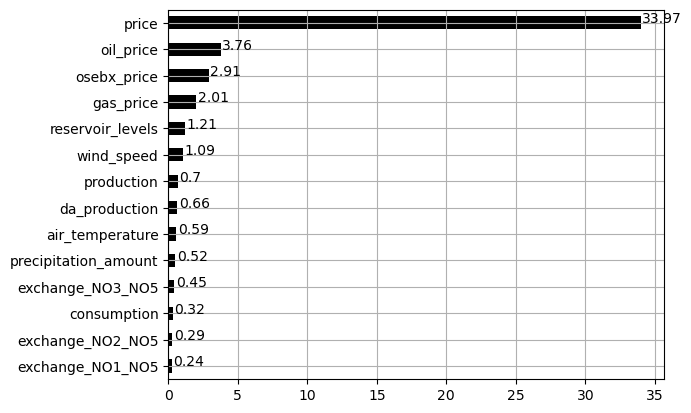

In [82]:
# create a pandas series and sort by values
feature_importance = pd.Series(feature_importance).sort_values()

# create horizontal bar chart
ax = feature_importance.plot(kind='barh', color='black', grid=True)

# loop over series and annotate bars
for i, v in enumerate(feature_importance):
    ax.text(v + 0.1, i, str(round(v, 2)), color='black')
    
# show plot
plt.show()

In [83]:

# load dataset
data = pd.read_csv('/Users/markuswiikjensen/Desktop/Master-Data/Final_data/NO6_preprocessed.csv', parse_dates=['datetime'])

data=data.set_index('datetime')
data.drop('reservoir_capacity', 1, inplace=True)




/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/2727225476.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  data.drop('reservoir_capacity', 1, inplace=True)


In [84]:
def prepare_data(data):
    steps = 24
    dataset_for_prediction = data.copy()
    dataset_for_prediction['target'] = dataset_for_prediction['price'].shift(-steps)
    dataset_for_prediction = dataset_for_prediction.dropna()

    train_set = dataset_for_prediction[:365*24*3] 
    test_set = dataset_for_prediction[365*24*3:] 

    
    # split the data into input (X) and output (y)
    train_X = train_set.drop('target', axis=1).values
    train_y = train_set['target'].values
    test_X = test_set.drop('target', axis=1).values
    test_y = test_set['target'].values

    # apply min-max scaling to the input and output data
    scaler_X = MinMaxScaler(feature_range=(-1, 1))
    train_X = scaler_X.fit_transform(train_X)
    test_X = scaler_X.transform(test_X)

    scaler_y = MinMaxScaler(feature_range=(-1, 1))
    train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))
    test_y = scaler_y.transform(test_y.reshape(-1, 1))

    return train_X, train_y, test_X, test_y, scaler_X, scaler_y,  train_set, test_set

In [85]:
train_X, train_y, test_X, test_y, scaler_X, scaler_y, train_set, test_set= prepare_data(data)

In [86]:
tscv = TimeSeriesSplit(n_splits=365, test_size=24)

In [87]:

val_preds=[]
rmse=[]
mape=[]
mae=[]
forecast=pd.Series()
for train_index, val_index in tqdm(tscv.split(train_X)):
    X_train, X_val = train_X[train_index], train_X[val_index]
    y_train, y_val = train_y[train_index], train_y[val_index]
    
    train_dmatrix = xgb.DMatrix(X_train, label=y_train)
    test_dmatrix = xgb.DMatrix(X_val, label=y_val)
    
        # set hyperparameters
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'max_depth': 3,
        'eta': 0.1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'lambda':0.2
    }

    # train model
    num_rounds = 100
    model = xgb.train(params, train_dmatrix, num_rounds)

    # predict on test set
    preds = model.predict(test_dmatrix)

    # invert scaling to get unscaled predictions
    preds = preds.reshape(-1, 1)
    preds = scaler_y.inverse_transform(preds)

    y_val = np.array(y_val).reshape(-1, 1)
    y_val = scaler_y.inverse_transform(y_val)
    
    forecast = pd.concat([forecast, pd.Series(preds.ravel())])
    val_preds.append(preds)
    mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
    rmse.append(np.sqrt(mean_squared_error(y_val, preds)))
    mae.append(mean_absolute_error(y_val, preds))
    

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  forecast=pd.Series()
280it [05:39,  1.27s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:40: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
314it [06:23,  1.44s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:40: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
315it [06:25,  1.53s/it]/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/960740294.py:40: RuntimeWarning: divide by zero encountered in divide
  mape.append(np.mean(np.abs((y_val - preds) / y_val)) * 100)
365it [07:36,  1.25s/it]


In [88]:
# compute the residuals
residuals = train_set['target'][365*24*2:].values - val_preds

# compute the RSS
rss = np.sum(residuals**2)
print("Residual Sum of Squares (RSS): ", rss)
print("Mean MAE:", np.mean(mae))
print("Mean RMSE:", np.mean(rmse))
print("Mean MAPE:", np.mean(mape))

Residual Sum of Squares (RSS):  6.163548175184559e+17
Mean MAE: 18979.327229259437
Mean RMSE: 22915.914802122104
Mean MAPE: inf


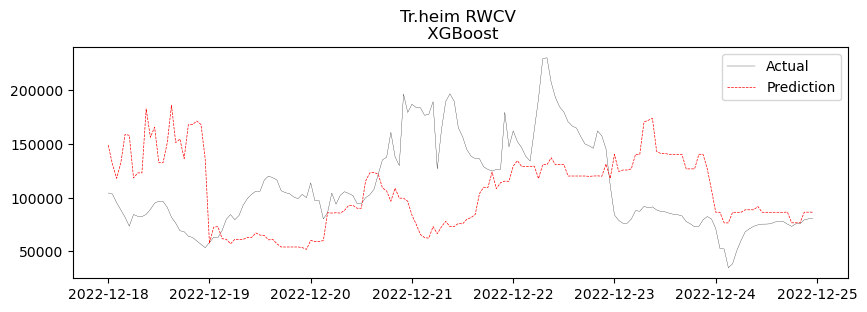

In [89]:
# Define x-axis values
x_pred = np.arange(8760)
x_actual = np.arange(26280)

train_set.index.freq = 'H'

# Plot the data
plt.figure(figsize=(10, 3))
plt.plot(train_set.index[-24*14:-24*7].shift(24), train_set['target'][-24*14:-24*7].values, label='Actual', linewidth=0.2,  c='black')
plt.plot(train_set.index[-24*14:-24*7].shift(24), forecast[-24*14:-24*7], label='Prediction', linewidth=0.5, linestyle='--', c='r')
plt.title('Tr.heim RWCV \n XGBoost')
plt.legend()
plt.show()



In [90]:
morning_mask = (train_set.iloc[-365*24:].index.hour >= 6) & (train_set.iloc[-365*24:].index.hour < 12)
midday_mask = (train_set.iloc[-365*24:].index.hour >= 12) & (train_set.iloc[-365*24:].index.hour < 15)
evening_mask = (train_set.iloc[-365*24:].index.hour >= 15) & (train_set.iloc[-365*24:].index.hour < 21)
night_mask = (train_set.iloc[-365*24:].index.hour >= 21) | (train_set.iloc[-365*24:].index.hour < 6)

preds=pd.Series(forecast.values, index=train_set.iloc[-365*24:].index.values)
actual= pd.Series(train_set.iloc[-365*24:]['target'].values, index=train_set.iloc[-365*24:].index.values)

rmse_morning_scores= np.sqrt(mean_squared_error(actual[morning_mask], preds[morning_mask]))
rmse_morning_scores

rmse_midday_scores= np.sqrt(mean_squared_error(actual[midday_mask], preds[midday_mask]))
rmse_midday_scores

rmse_evening_scores= np.sqrt(mean_squared_error(actual[evening_mask], preds[evening_mask]))
rmse_evening_scores

rmse_night_scores= np.sqrt(mean_squared_error(actual[night_mask], preds[night_mask]))
rmse_night_scores

rmse_scores=pd.Series((rmse_morning_scores,rmse_midday_scores,rmse_evening_scores, rmse_night_scores))


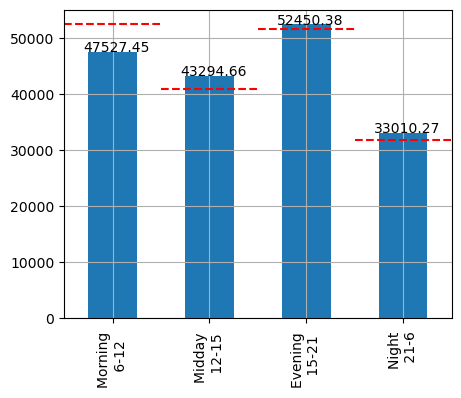

In [91]:
rmse_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(rmse_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    
for i, v in enumerate(rmse_scores):
    if i == 0:
        plt.axhline(y=52421, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 1:
        plt.axhline(y=40960, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 2:
        plt.axhline(y=51591, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    elif i == 3:
        plt.axhline(y=31766, color='r', linestyle='--', xmin=i / len(rmse_scores), xmax=(i + 1) / len(rmse_scores))
    
    
    


plt.show()

In [92]:
mae_morning_scores = mean_absolute_error(actual[morning_mask], preds[morning_mask])
mae_midday_scores = mean_absolute_error(actual[midday_mask], preds[midday_mask])
mae_evening_scores = mean_absolute_error(actual[evening_mask], preds[evening_mask])
mae_night_scores = mean_absolute_error(actual[night_mask], preds[night_mask])

mae_scores = pd.Series((mae_morning_scores, mae_midday_scores, mae_evening_scores, mae_night_scores))


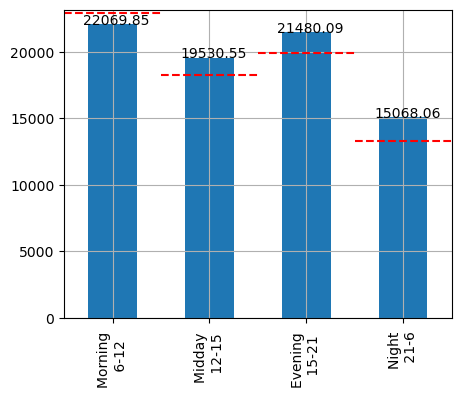

In [93]:
mae_scores.plot(kind='bar', figsize=(5,4), grid=True)
plt.xticks(ticks=(0, 1, 2, 3), labels=('Morning \n 6-12', 'Midday \n 12-15', 'Evening \n 15-21', 'Night \n 21-6'))

# Annotate the RMSE scores on the bar chart
for i, v in enumerate(mae_scores):
    plt.annotate(str(round(v,2)), xy=(i-0.3, v))
    

for i, v in enumerate(mae_scores):
    if i == 0:
        plt.axhline(y=22891, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 1:
        plt.axhline(y=18225, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 2:
        plt.axhline(y=19937, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))
    elif i == 3:
        plt.axhline(y=13290, color='r', linestyle='--', xmin=i / len(mae_scores), xmax=(i + 1) / len(mae_scores))


plt.show()

Residual Sum of Squares (RSS):  1695508435419.113
RMSE: 28326.9769, MAPE: 31.7090% , MAE:  19532.8290, RSS:  1695508435419.1130


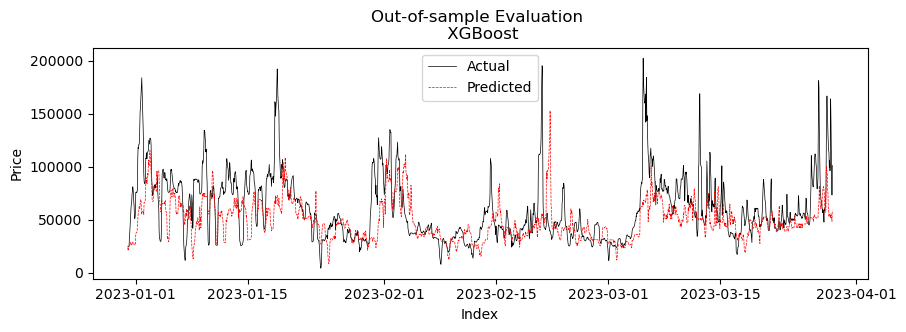

In [94]:

# prepare data
train_dmatrix = xgb.DMatrix(train_X, label=train_y)
test_dmatrix = xgb.DMatrix(test_X, label=test_y)

# set hyperparameters
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'lambda':0.2
}

# train model
num_rounds = 100
model = xgb.train(params, train_dmatrix, num_rounds)

# predict on test set
preds = model.predict(test_dmatrix)

# invert scaling to get unscaled predictions
preds = preds.reshape(-1, 1)
preds = scaler_y.inverse_transform(preds)

test_y = np.array(test_y).reshape(-1, 1)
test_y = scaler_y.inverse_transform(test_y)

# calculate RMSE and MAPE
rmse = np.sqrt(mean_squared_error(test_y, preds))
mape = np.mean(np.abs((test_y - preds) / test_y)) * 100
mae= mean_absolute_error(test_y, preds)

# compute the residuals
residuals = test_y - preds

# compute the RSS
rss = np.sum(residuals**2)

print("Residual Sum of Squares (RSS): ", rss)

print(f'RMSE: {rmse:.4f}, MAPE: {mape:.4f}% , MAE: {mae: .4f}, RSS: {rss: .4f}')

# plot actual vs predicted values
plt.figure(figsize=(10, 3))
plt.plot(test_set.index, test_y, label='Actual', linewidth=0.5, c='black')
plt.plot(test_set.index, preds, label='Predicted', linewidth=0.5, linestyle='--', c='r')

plt.xlabel('Index')
plt.ylabel('Price')
plt.title('Out-of-sample Evaluation \n XGBoost')
plt.legend()
plt.show()


In [95]:
orig_feature_names = train_set.drop('target', 1).columns
orig_feature_names

/var/folders/qt/z8wfyvqx1l55qqc_y_5n83fc0000gn/T/ipykernel_43227/2618380972.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  orig_feature_names = train_set.drop('target', 1).columns


Index(['price', 'consumption', 'production', 'da_production',
       'exchange_NO1_NO6', 'exchange_NO6_NO4', 'exchange_NO6_NO5',
       'exchange_NO6_SE2', 'air_temperature', 'wind_speed',
       'precipitation_amount', 'reservoir_levels', 'oil_price', 'gas_price',
       'osebx_price'],
      dtype='object')

In [96]:
importance = model.get_score(importance_type='gain')
importance

{'f0': 8.59579849243164,
 'f1': 0.42976081371307373,
 'f2': 0.5492040514945984,
 'f3': 0.622761607170105,
 'f4': 0.2490709275007248,
 'f5': 0.5424126982688904,
 'f6': 0.6308667063713074,
 'f7': 0.24877355992794037,
 'f8': 2.100362777709961,
 'f9': 0.499798983335495,
 'f10': 0.7713072896003723,
 'f11': 1.0507687330245972,
 'f12': 3.264683961868286,
 'f13': 1.630454421043396,
 'f14': 1.3685719966888428}

In [97]:
feature_importance = {orig_feature_names[int(key[1:])]: value for key, value in importance.items()}
feature_importance

{'price': 8.59579849243164,
 'consumption': 0.42976081371307373,
 'production': 0.5492040514945984,
 'da_production': 0.622761607170105,
 'exchange_NO1_NO6': 0.2490709275007248,
 'exchange_NO6_NO4': 0.5424126982688904,
 'exchange_NO6_NO5': 0.6308667063713074,
 'exchange_NO6_SE2': 0.24877355992794037,
 'air_temperature': 2.100362777709961,
 'wind_speed': 0.499798983335495,
 'precipitation_amount': 0.7713072896003723,
 'reservoir_levels': 1.0507687330245972,
 'oil_price': 3.264683961868286,
 'gas_price': 1.630454421043396,
 'osebx_price': 1.3685719966888428}

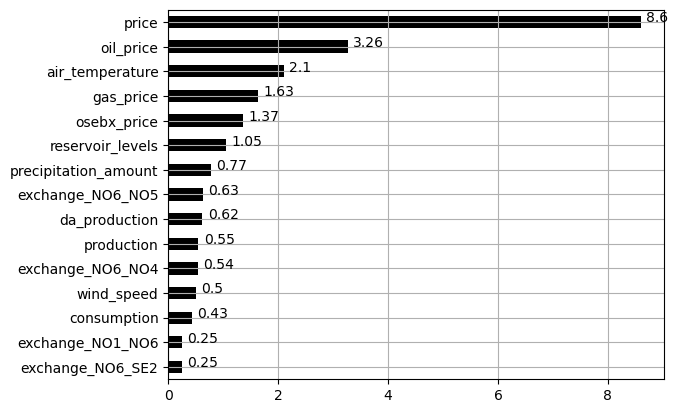

In [98]:
# create a pandas series and sort by values
feature_importance = pd.Series(feature_importance).sort_values()

# create horizontal bar chart
ax = feature_importance.plot(kind='barh', color='black', grid=True)

# loop over series and annotate bars
for i, v in enumerate(feature_importance):
    ax.text(v + 0.1, i, str(round(v, 2)), color='black')
    
# show plot
plt.show()